Elapsed time: 10781.818425893784


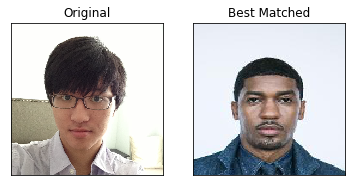

In [6]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import array
import os, os.path

q1_img1_path = "/Users/Will/Desktop/selfie.png"
q1_img1 = cv2.imread(q1_img1_path)
q1_img2 = q1_img1.copy()
q1_img2 = cv2.resize(q1_img2, (128, 128), interpolation=cv2.INTER_CUBIC)
q1_img2_gray = cv2.cvtColor(q1_img2, cv2.COLOR_BGR2GRAY) #convert to gray-scale
q1_img2_padded = cv2.copyMakeBorder(q1_img2_gray, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0) #zero-padding

q1_img_celeb_path = "/Users/Will/Desktop/img_align_celeb/"
folder = os.listdir(q1_img_celeb_path)

#loop through the image folder and import the file directory as array
image_path_list = []
for images in folder:
    image_path_list.append(os.path.join(q1_img_celeb_path, images))

B = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
height, width = q1_img2.shape[:2]

#Compute the value via LBP Operator
def LBP_Operator(image, row, col):
    binary = ""
    for i in range(0, 3):
        for j in range(0, 3):
            B[i, j] = image[i + row, j + col]
    center = B[1, 1]
    for i in range(0, 3):
        for j in range(0, 3):
            if B[i,j] >= center:
                B[i,j] = 1
            else:
                B[i,j] = 0
    binary = str(B[1, 0]) + str(B[2, 0]) + str(B[2, 1]) + str(B[2, 2]) + str(B[1, 2]) + str(B[0, 2]) + str(B[0, 1]) + str(B[0, 0])
    return binary

#compute value for each section of selfie (each section is composed by 18*18 pixels)
def compute_selfie_cell(row_cell, col_cell):
    selfie_lst = [0] * 256
    row_min = 0 + 18*row_cell
    row_max = 18 + 18*row_cell
    col_min = 0 + 18*col_cell
    col_max = 18 + 18*col_cell
    for row in range(row_min, row_max):
        for col in range(col_min, col_max):
            selfie_bin = LBP_Operator(q1_img2_padded, row, col)
            selfie_decimal = int(selfie_bin, 2)
            selfie_lst[selfie_decimal] += 1
    return selfie_lst

#same as above, but on the celebrity's photo instead
def compute_celeb_cell(row_cell, col_cell, image):
    celeb_lst = [0] * 256
    row_min = 0 + 18*row_cell
    row_max = 18 + 18*row_cell
    col_min = 0 + 18*col_cell
    col_max = 18 + 18*col_cell
    for row in range(row_min, row_max):
        for col in range(col_min, col_max):
            celeb_bin = LBP_Operator(image, row, col)
            celeb_decimal = int(celeb_bin, 2)
            celeb_lst[celeb_decimal] += 1
    return celeb_lst

t0 = time.time() 

#compute all 7*7 sections of values for selfie and store them into `selfie_global_dec`
selfie_global_dec = []
for row_cell in range(0, 7):
    for col_cell in range(0, 7):
        selfie_cell_desc = compute_selfie_cell(row_cell, col_cell)
        selfie_global_dec.append(list(selfie_cell_desc))

#random minimum sum of squared difference
min_ssd = 10000  
current_ssd = 10000
min_photo = q1_img1_path

for images in image_path_list:
    #import the celebrity image (one per loop)
    q1_img_celeb = cv2.imread(images)
    q1_img_celeb = cv2.resize(q1_img_celeb, (128, 128), interpolation=cv2.INTER_CUBIC)
    q1_celeb_gray = cv2.cvtColor(q1_img_celeb, cv2.COLOR_BGR2GRAY) #convert to gray-scale
    q1_img_celeb_padded = cv2.copyMakeBorder(q1_celeb_gray, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0) #zero-padding

    #compute all 7*7 sections of values for selfie and store them into `selfie_global_dec`
    celeb_global_dec = []
    for row_cell in range(0, 7):
        for col_cell in range(0, 7):
            celeb_cell_desc = compute_celeb_cell(row_cell, col_cell, q1_img_celeb_padded)
            celeb_global_dec.append(list(celeb_cell_desc))

    curr_ssd = 0
    total_ssd = 0
    #loop to compare the values for 49 sections
    for cell in range(0, 49):
        curr_self_cell = selfie_global_dec[cell]
        curr_celeb_cell = celeb_global_dec[cell]
        min_self = min(curr_self_cell)
        max_self = max(curr_self_cell)
        min_celeb = min(curr_celeb_cell)
        max_celeb = max(curr_celeb_cell)
        for m in range(0, 256):
            #normalize the value
            norm_self = (curr_self_cell[m] - min_self)/(max_self - min_self)
            norm_celeb = (curr_celeb_cell[m] - min_celeb)/(max_celeb - min_celeb)
            #compute the difference between the two values
            diff = norm_self - norm_celeb
            #adjust the weight of sections depends on their location (less on the sides, more in center)
            if row_cell == 0 or col_cell == 0:
                curr_ssd = 0.1(diff**2)
            elif row_cell == 1 or col_cell == 1:
                curr_ssd = 0.3(diff**2)
            elif row_cell == 2 or col_cell == 2:
                curr_ssd = 0.5(diff**2)
            else:
                curr_ssd = diff**2

            total_ssd = total_ssd + curr_ssd
    
    #record the minimum SSD and save that image directory for display later       
    if total_ssd < min_ssd:
        min_ssd = total_ssd
        min_photo = images
    

matched = cv2.imread(min_photo)
matched = cv2.resize(matched, (128, 128), interpolation=cv2.INTER_CUBIC)

print("Elapsed time:", time.time() - t0)

#convert the image to RGB
q1_img1 = cv2.cvtColor(q1_img1, cv2.COLOR_BGR2RGB)
q1_img2 = cv2.cvtColor(matched, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(121), plt.imshow(q1_img1, cmap="gray")
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(q1_img2, cmap="gray")
plt.title("Best Matched"), plt.xticks([]), plt.yticks([])
plt.show()

Elapsed time: 9.346084117889404


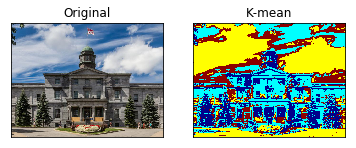

In [7]:
#K-Mean Clustering (K = 4)


import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
q2_img1_path = "/Users/Will/Desktop/mcgill3.jpeg"
q2_img1 = cv2.imread(q2_img1_path)

q2_img2 = q2_img1.copy()
q2_img2_gray = cv2.cvtColor(q2_img2, cv2.COLOR_BGR2GRAY) #convert to gray-scale

height, width = q2_img2_gray.shape[:2]

#generate random cluster center
def generate_random_centers():
    rand_h = np.random.randint(0, height)
    rand_w = np.random.randint(0, width)
    rand_intensity = q2_img2_gray[rand_h, rand_w]
    position = (rand_h, rand_w)
    center = rand_intensity
    return center, position

#group clusters together depending on the difference to the four initial cluster center
def find_cluster_group(n):
    clusters = [center1, center2, center3, center4]
    min_dist = 10000
    group = 0
    for i in range(0, len(clusters)):
        diff = abs(int(clusters[i]) - int(n))
        if diff < min_dist:
            min_dist = diff
            group = i + 1
    return group
    
center1, pos1 = generate_random_centers()
center2, pos2 = generate_random_centers()
center3, pos3 = generate_random_centers()
center4, pos4 = generate_random_centers()

attempt = 0
loop = 1
t0 = time.time()
#continue to loop
while(loop == 1):
    clusters1_pos = []
    clusters2_pos = []
    clusters3_pos = []
    clusters4_pos = []
    clusters1_int = []
    clusters2_int = []
    clusters3_int = []
    clusters4_int = []
    for row in range(0, height):
        for col in range(0, width):
            intensity = q2_img2_gray[row, col]
            pos = (row, col)
            group_no = find_cluster_group(intensity)
            #save the intensity and its location
            if group_no == 1:
                clusters1_int.append(intensity)
                clusters1_pos.append(pos)  
            elif group_no == 2:
                clusters2_int.append(intensity)
                clusters2_pos.append(pos)
            elif group_no == 3:
                clusters3_int.append(intensity)
                clusters3_pos.append(pos)
            else:
                clusters4_int.append(intensity)
                clusters4_pos.append(pos)
   
    #determine the mean of the cluster and in order to determine whether the point has converged.
    new_center1 = int(np.mean(clusters1_int))
    new_center2 = int(np.mean(clusters2_int))
    new_center3 = int(np.mean(clusters3_int))
    new_center4 = int(np.mean(clusters4_int))
    
    #if the new cluster centers equal the last cluster centers. The points have convered. Exit the loop
    count = 0
    if abs(new_center1 - center1) >= 1:
        center1 = new_center1
        count += 1
    if abs(new_center2 - center2) >= 1:
        center2 = new_center2
        count += 1
    if abs(new_center3 - center3) >= 1:
        center3 = new_center3
        count += 1
    if abs(new_center4 - center4) >= 1:
        center4 = new_center4
        count += 1
    
    if count < 1:
        loop = 0

#color the clusters depends on the group they're in
#K = 2 --> 4 colours
for x in range(0, len(clusters1_pos)):
    q2_img2[clusters1_pos[x][0], clusters1_pos[x][1]] = (255, 255, 0)
for x in range(0, len(clusters2_pos)):
    q2_img2[clusters2_pos[x][0], clusters2_pos[x][1]] = (0, 255, 255)
for x in range(0, len(clusters3_pos)):
    q2_img2[clusters3_pos[x][0], clusters3_pos[x][1]] = (139, 0, 0)
for x in range(0, len(clusters4_pos)):
    q2_img2[clusters4_pos[x][0], clusters4_pos[x][1]] = (0, 0, 139)

print("Elapsed time:", time.time() - t0)

cv2.imwrite('/Users/Will/Desktop/Assign3/K-mean2.jpg', q2_img2)

#convert the image to RGB
q2_img1 = cv2.cvtColor(q2_img1, cv2.COLOR_BGR2RGB)
q2_img2 = cv2.cvtColor(q2_img2, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(121), plt.imshow(q2_img1, cmap="gray")
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(q2_img2, cmap="gray")
plt.title("K-mean"), plt.xticks([]), plt.yticks([])
plt.show()

Elapsed time: 60.380131006240845


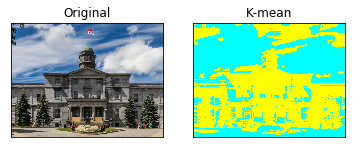

In [8]:
#K-Mean Clustering (K = 2)
    #This part is same as above, the only difference is that K = 2 which indiciates that there's only 2 groups. 
    #Reduced the number of array from 4 to 2 as well as random point generated.

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
q2_img1_path = "/Users/Will/Desktop/mcgill3.jpeg"
q2_img1 = cv2.imread(q2_img1_path)

q2_img2 = q2_img1.copy()
q2_img2_gray = cv2.cvtColor(q2_img2, cv2.COLOR_BGR2GRAY) #convert to gray-scale

height, width = q2_img2_gray.shape[:2]

def generate_random_centers():
    rand_h = np.random.randint(0, height)
    rand_w = np.random.randint(0, width)
    rand_intensity = q2_img2_gray[rand_h, rand_w]
    position = (rand_h, rand_w)
    center = rand_intensity
    return center, position

def find_cluster_group(n):
    clusters = [center1, center2]
    min_dist = 10000
    group = 0
    for i in range(0, len(clusters)):
        diff = abs(int(clusters[i]) - int(n))
        if diff < min_dist:
            min_dist = diff
            group = i + 1
    return group
    
center1, pos1 = generate_random_centers()
center2, pos2 = generate_random_centers()

loop = 1
while(loop == 1):
    clusters1_pos = []
    clusters2_pos = []
    clusters1_int = []
    clusters2_int = []
    for row in range(0, height):
        for col in range(0, width):
            intensity = q2_img2_gray[row, col]
            pos = (row, col)
            group_no = find_cluster_group(intensity)
            if group_no == 1:
                clusters1_int.append(intensity)
                clusters1_pos.append(pos)  
            else:
                clusters2_int.append(intensity)
                clusters2_pos.append(pos)
                
    new_center1 = int(np.mean(clusters1_int))
    new_center2 = int(np.mean(clusters2_int))
    
    count = 0
    if abs(new_center1 - center1) >= 1:
        center1 = new_center1
        count += 1
    if abs(new_center2 - center2) >= 1:
        center2 = new_center2
        count += 1
    if count < 1:
        loop = 0
for x in range(0, len(clusters1_pos)):
    q2_img2[clusters1_pos[x][0], clusters1_pos[x][1]] = (255, 255, 0)
for x in range(0, len(clusters2_pos)):
    q2_img2[clusters2_pos[x][0], clusters2_pos[x][1]] = (0, 255, 255)

print("Elapsed time:", time.time() - t0)
cv2.imwrite('/Users/Will/Desktop/Assign3/K-mean2.jpg', q2_img2)

#convert the image to RGB
q2_img1 = cv2.cvtColor(q2_img1, cv2.COLOR_BGR2RGB)
q2_img2 = cv2.cvtColor(q2_img2, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(121), plt.imshow(q2_img1, cmap="gray")
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(q2_img2, cmap="gray")
plt.title("K-mean"), plt.xticks([]), plt.yticks([])
plt.show()

Elapsed time: 77.03800988197327


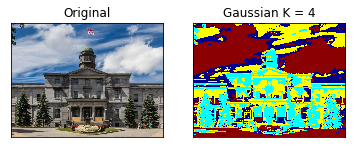

In [9]:
#Gaussian Mixture Model of Expectation-Maximization 

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

q2_img1_path = "/Users/Will/Desktop/mcgill3.jpeg"
q2_img1 = cv2.imread(q2_img1_path)
q2_img2 = q2_img1.copy()
q2_img2_gray = cv2.cvtColor(q2_img2, cv2.COLOR_BGR2GRAY) #convert to gray-scale
height, width = q2_img2_gray.shape[:2]

#compute the variance given the cluster groups and their means
def find_variance(clusters, means):
    variances = []
    for i in range(0, 4):
        mean = means[i]
        cluster = clusters[i]
        total_sum = 0
        length = len(cluster)
        for i in range (0, length):
            curr_sum = (cluster[i] - mean)**2
            total_sum = curr_sum + total_sum
        variance = total_sum/(length - 1)
        variance = math.sqrt(variance)
        variances.append(variance)
        
    return variances

#determine the cluster group an intensity belongs to.
#Expectation Step.
def find_group(intensity, means, clusters, variances):
    probabilities = []
    for i in range(0, 4):
        variance = variances[i]
        exp = math.e**((-1)*((intensity - means[i])**2)/(2*variance**2))
        curr_prob = (1/(variance*(math.sqrt(2*math.pi))))*exp
        probabilities.append(curr_prob)
        
    weights = []
    for i in range(0, 4):
        weight = len(clusters[i])/(height*width)
        weights.append(weight)
    
    max_expect = 0    
    for i in range(0, 4):
        curr_expect = (weights[i]*probabilities[i])/(weights[0]*probabilities[0] + weights[1]*probabilities[1] + weights[2]*probabilities[2] + weights[3]*probabilities[3])
        if curr_expect > max_expect:
            max_expect = curr_expect
            to_group = i + 1
            
    return to_group

#Assign the pixel to respective cluster group
def assign_to_group(intensity, row, col, group):
    pos = (row, col)
    if group == 1:
        new_clusters1_int.append(intensity)
        new_clusters1_pos.append(pos)  
    elif group == 2:
        new_clusters2_int.append(intensity)
        new_clusters2_pos.append(pos)
    elif group == 3:
        new_clusters3_int.append(intensity)
        new_clusters3_pos.append(pos)
    else:
        new_clusters4_int.append(intensity)
        new_clusters4_pos.append(pos)

#compute new means of the new cluster group in order to check for convergence        
def compute_new_means():
    new_mean1 = int(np.mean(new_clusters1_int))
    new_mean2 = int(np.mean(new_clusters2_int))
    new_mean3 = int(np.mean(new_clusters3_int))
    new_mean4 = int(np.mean(new_clusters4_int))
    new_means = [new_mean1, new_mean2, new_mean3, new_mean4]
    return new_means

#check if the points have converged.     
def check_convergence(new_means):
    for i in range(0, len(new_means)):
        if abs(new_means[i] - means[i]) >= 1:
            return 0
    return 1
        
new_clusters1_pos = []
new_clusters2_pos = []
new_clusters3_pos = []
new_clusters4_pos = []

new_clusters1_int = []
new_clusters2_int = []
new_clusters3_int = []
new_clusters4_int = []

array = np.array(q2_img2_gray)
array = np.reshape(array, height*width)
array = np.sort(array)

init_cluster_size = int((height*width)/4)
cluster1 = array[init_cluster_size*0:init_cluster_size*1]
cluster2 = array[init_cluster_size*1:init_cluster_size*2]
cluster3 = array[init_cluster_size*2:init_cluster_size*3]
cluster4 = array[init_cluster_size*3:init_cluster_size*4]
clusters = [cluster1, cluster2, cluster3, cluster4]

mean1 = int(np.mean(cluster1))
mean2 = int(np.mean(cluster2))
mean3 = int(np.mean(cluster3))
mean4 = int(np.mean(cluster4))
means = [mean1, mean2, mean3, mean4]

converged = 0
t0 = time.time()
while(converged == 0):
    #determine the variance to avoid repetition. A given set of clusters will result in the same variance
    variances = find_variance(clusters, means)
    for row in range(0, height):
        for col in range(0, width):
            intensity = q2_img2_gray[row, col]
            group = find_group(intensity, means, clusters, variances)
            assign_to_group(intensity, row, col, group)
    convergence = check_convergence(compute_new_means())
    #if the result did not converge. Set the new found clusters as the clusters used for computation
    if convergence == 0:
        clusters[0] = new_clusters1_int
        clusters[1] = new_clusters2_int
        clusters[2] = new_clusters3_int
        clusters[3] = new_clusters4_int
        mean1 = int(np.mean(clusters[0]))
        mean2 = int(np.mean(clusters[1]))
        mean3 = int(np.mean(clusters[2]))
        mean4 = int(np.mean(clusters[3]))
        means = [mean1, mean2, mean3, mean4]
    else:
        break
        
for x in range(0, len(new_clusters1_pos)):
    q2_img2[new_clusters1_pos[x][0], new_clusters1_pos[x][1]] = (255, 255, 0)
for x in range(0, len(new_clusters2_pos)):
    q2_img2[new_clusters2_pos[x][0], new_clusters2_pos[x][1]] = (0, 255, 255)
for x in range(0, len(new_clusters3_pos)):
    q2_img2[new_clusters3_pos[x][0], new_clusters3_pos[x][1]] = (139, 0, 0)
for x in range(0, len(new_clusters4_pos)):
    q2_img2[new_clusters4_pos[x][0], new_clusters4_pos[x][1]] = (0, 0, 139)

cv2.imwrite('/Users/Will/Desktop/Assign3/Gaussian4.jpg', q2_img2)
print("Elapsed time:", time.time() - t0)

#convert the image to RGB
q2_img1 = cv2.cvtColor(q2_img1, cv2.COLOR_BGR2RGB)
q2_img2 = cv2.cvtColor(q2_img2, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(121), plt.imshow(q2_img1, cmap="gray")
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(q2_img2, cmap="gray")
plt.title("Gaussian K = 4"), plt.xticks([]), plt.yticks([])
plt.show()

Elapsed time: 27.472990036010742


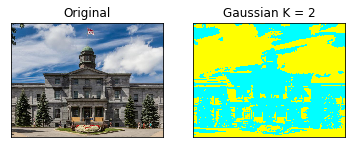

In [10]:
#Gaussian Mixture Model of Expectation-Maximization 

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

q2_img1_path = "/Users/Will/Desktop/mcgill3.jpeg"
q2_img1 = cv2.imread(q2_img1_path)
q2_img2 = q2_img1.copy()
q2_img2_gray = cv2.cvtColor(q2_img2, cv2.COLOR_BGR2GRAY) #convert to gray-scale
height, width = q2_img2_gray.shape[:2]

#compute the variance given the cluster groups and their means
def find_variance(clusters, means):
    variances = []
    for i in range(0, 2):
        mean = means[i]
        cluster = clusters[i]
        total_sum = 0
        length = len(cluster)
        for i in range (0, length):
            curr_sum = (cluster[i] - mean)**2
            total_sum = curr_sum + total_sum
        variance = total_sum/(length - 1)
        variance = math.sqrt(variance)
        variances.append(variance)
    return variances

#determine the cluster group an intensity belongs to.
#Expectation Step.
def find_group(intensity, means, clusters, variances):
    probabilities = []
    for i in range(0, 2):
        variance = variances[i]
        exp = math.e**((-1)*((intensity - means[i])**2)/(2*variance**2))
        curr_prob = (1/(variance*(math.sqrt(2*math.pi))))*exp
        probabilities.append(curr_prob)
        
    weights = []
    for i in range(0, 2):
        weight = len(clusters[i])/(height*width)
        weights.append(weight)
    
    max_expect = 0    
    for i in range(0, 2):
        curr_expect = (weights[i]*probabilities[i])/(weights[0]*probabilities[0] + weights[1]*probabilities[1])
        if curr_expect > max_expect:
            max_expect = curr_expect
            to_group = i + 1
    return to_group

#Assign the pixel to respective cluster group
def assign_to_group(intensity, row, col, group):
    pos = (row, col)
    if group == 1:
        new_clusters1_int.append(intensity)
        new_clusters1_pos.append(pos)  
    else:
        new_clusters2_int.append(intensity)
        new_clusters2_pos.append(pos)


#compute new means of the new cluster group in order to check for convergence        
def compute_new_means():
    new_mean1 = int(np.mean(new_clusters1_int))
    new_mean2 = int(np.mean(new_clusters2_int))
    new_means = [new_mean1, new_mean2]
    return new_means

#check if the points have converged.     
def check_convergence(new_means):
    for i in range(0, len(new_means)):
        if abs(new_means[i] - means[i]) >= 1:
            return 0
    return 1
        
new_clusters1_pos = []
new_clusters2_pos = []

new_clusters1_int = []
new_clusters2_int = []

array = np.array(q2_img2_gray)
array = np.reshape(array, height*width)
array = np.sort(array)

init_cluster_size = int((height*width)/2)
cluster1 = array[init_cluster_size*0:init_cluster_size*1]
cluster2 = array[init_cluster_size*1:init_cluster_size*2]
clusters = [cluster1, cluster2]

mean1 = int(np.mean(cluster1))
mean2 = int(np.mean(cluster2))
means = [mean1, mean2]

converged = 0
t0 = time.time()
while(converged == 0):
    #determine the variance to avoid repetition. A given set of clusters will result in the same variance
    variances = find_variance(clusters, means)
    for row in range(0, height):
        for col in range(0, width):
            intensity = q2_img2_gray[row, col]
            group = find_group(intensity, means, clusters, variances)
            assign_to_group(intensity, row, col, group)
    convergence = check_convergence(compute_new_means())
    #if the result did not converge. Set the new found clusters as the clusters used for computation
    if convergence == 0:
        clusters[0] = new_clusters1_int
        clusters[1] = new_clusters2_int
        mean1 = int(np.mean(clusters[0]))
        mean2 = int(np.mean(clusters[1]))
        means = [mean1, mean2]
    else:
        break

for x in range(0, len(new_clusters1_pos)):
    q2_img2[new_clusters1_pos[x][0], new_clusters1_pos[x][1]] = (255, 255, 0)
for x in range(0, len(new_clusters2_pos)):
    q2_img2[new_clusters2_pos[x][0], new_clusters2_pos[x][1]] = (0, 255, 255)

print("Elapsed time:", time.time() - t0)
cv2.imwrite('/Users/Will/Desktop/Assign3/Gaussian2.jpg', q2_img2)

#convert the image to RGB
q2_img1 = cv2.cvtColor(q2_img1, cv2.COLOR_BGR2RGB)
q2_img2 = cv2.cvtColor(q2_img2, cv2.COLOR_BGR2RGB)

# display images
plt.subplot(121), plt.imshow(q2_img1, cmap="gray")
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(q2_img2, cmap="gray")
plt.title("Gaussian K = 2"), plt.xticks([]), plt.yticks([])
plt.show()